In [2]:
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
import pandas as pd
import yfinance as yf
import datetime
import requests
import io
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extracting Data from Yahoo Finance & Wikipedia API

In [3]:

def get_sp500_tickers():
    """
    Scrapes the current list of S&P 500 companies from Wikipedia.
    """
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        tables = pd.read_html(io.StringIO(response.text))
        df = tables[0]
        tickers = df['Symbol'].tolist()
        tickers = [ticker.replace('.', '-') for ticker in tickers]
        return tickers
    except Exception as e:
        print(f"Error fetching tickers: {e}")
        return []

def download_historical_data(tickers, start_date, end_date):
    """
    Downloads historical data for a list of tickers using yfinance.
    """
    print(f"Downloading data for {len(tickers)} tickers from {start_date} to {end_date}...")
    data = yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date,
        group_by='ticker',
        auto_adjust=True,
        threads=True
    )
    return data

def process_and_save_data(raw_data, filename="sp500_data.parquet"):
    print("Processing data structure (Flattening MultiIndex)...")


    df_tidy = raw_data.stack(level=0).reset_index().rename(columns={'level_1': 'Ticker'})


    df_tidy.columns = [col.replace(' ', '_') for col in df_tidy.columns]


    if 'Adj_Close' in df_tidy.columns:

        if df_tidy['Adj_Close'].isna().all():
            print("Dropping empty 'Adj_Close' column (Data is already auto-adjusted).")
            df_tidy = df_tidy.drop(columns=['Adj_Close'])


    original_len = len(df_tidy)
    df_tidy = df_tidy.dropna(subset=['Close'])
    print(f"Dropped {original_len - len(df_tidy)} rows with missing price data.")

    print(f"New Data Shape: {df_tidy.shape}")
    print(f"Saving to {filename}...")

    df_tidy.to_parquet(filename, index=False)
    print("Save completed successfully.")

# Execution Flow
if __name__ == "__main__":

    sp500_tickers = get_sp500_tickers()

    if sp500_tickers:

        end_date = datetime.datetime.today().strftime('%Y-%m-%d')
        start_date = (datetime.datetime.today() - datetime.timedelta(days=365*5)).strftime('%Y-%m-%d')

        raw_market_data = download_historical_data(sp500_tickers, start_date, end_date)

        process_and_save_data(raw_market_data, "sp500_historical_data.parquet")

# Loading Data & EDA

In [4]:
full_dataset = pd.read_parquet("sp500_historical_data.parquet")

In [5]:
full_dataset.head()

,Date,Ticker,Open,High,Low,Close,Volume
0,2020-12-29,A,114.599276,115.140573,112.927074,113.313713,1007400.0
1,2020-12-29,AAPL,134.385091,135.105436,130.773576,131.289505,121047300.0
2,2020-12-29,ABBV,85.538297,86.706790,85.538297,86.155457,5096400.0
3,2020-12-29,ABNB,150.000000,151.651001,143.119995,150.000000,5402300.0
4,2020-12-29,ABT,99.129980,99.531984,98.801069,98.974663,2834400.0


## Creating new features & Extract sector names from wikipwdia API

Generating Advanced Features...
Running Global Business EDA...


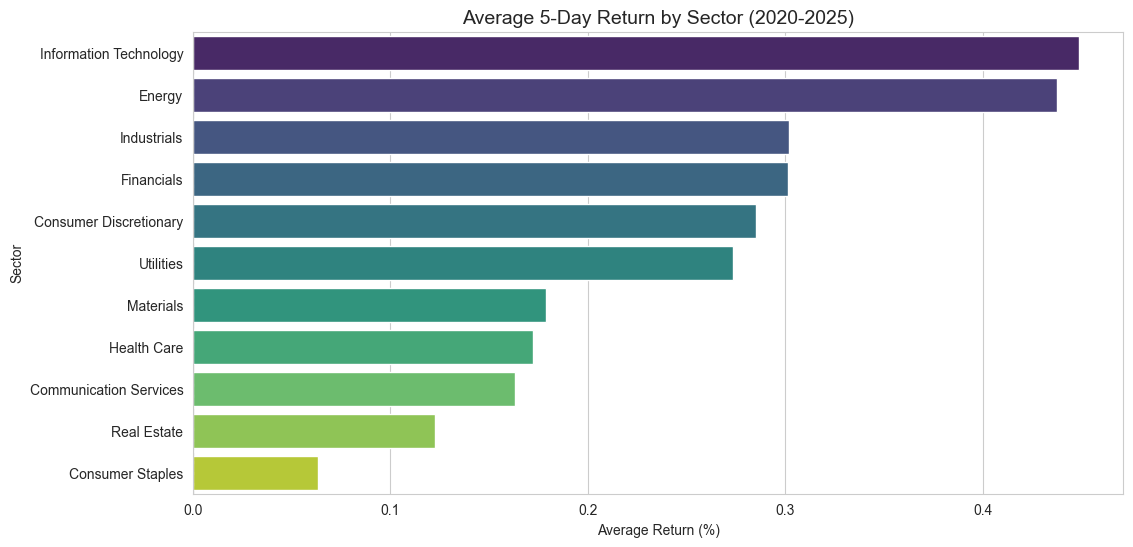

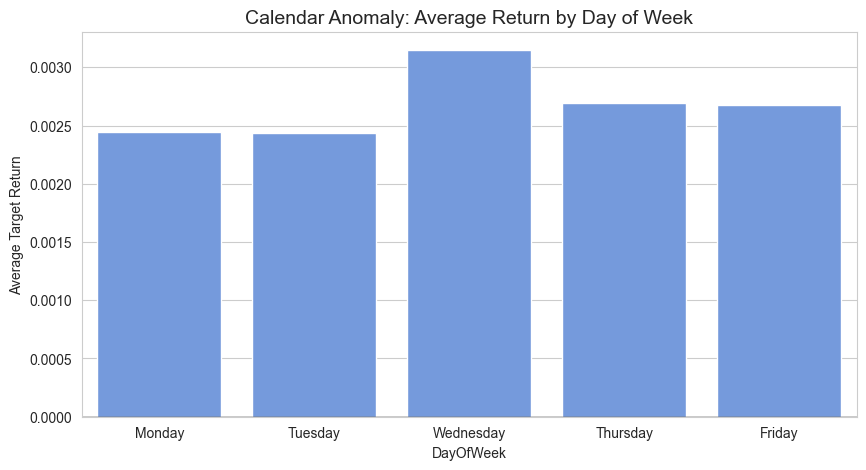

In [6]:

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Several functions of features creation

def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def add_features(df):
    print("Generating Advanced Features...")
    df = df.copy()
    df = df.sort_values(['Ticker', 'Date'])

    df['Log_Return'] = df.groupby('Ticker')['Close'].transform(lambda x: np.log(x / x.shift(1)))
    df['Volatility_20'] = df.groupby('Ticker')['Log_Return'].transform(lambda x: x.rolling(20).std())
    df['Vol_MA_20'] = df.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(20).mean())
    df['Rel_Volume'] = df['Volume'] / df['Vol_MA_20']
    df['SMA_50'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(50).mean())
    df['Dist_SMA_50'] = (df['Close'] / df['SMA_50']) - 1
    df['RSI'] = df.groupby('Ticker')['Close'].transform(lambda x: calculate_rsi(x))

    # adding LAG features (1,3,5 days behavior)

    df['Return_Lag_1'] = df.groupby('Ticker')['Log_Return'].shift(1)
    df['Return_Lag_3'] = df.groupby('Ticker')['Log_Return'].shift(3)
    df['Return_Lag_5'] = df.groupby('Ticker')['Log_Return'].shift(5)

    # adding datetime features

    df['Day_of_Week'] = df['Date'].dt.dayofweek # 0=Monday, 4=Friday
    df['Is_Month_End'] = df['Date'].dt.is_month_end.astype(int)

    # adding MACD feature (short 12 / long 26)

    ema12 = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    ema26 = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
    df['MACD'] = ema12 - ema26
    df['MACD_Signal'] = df.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
    # המרחק בין ה-MACD לסיגנל הוא האינדיקטור הכי חזק לשינוי כיוון
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']


    # define the target variable

    df['Target_5D_Return'] = df.groupby('Ticker')['Close'].transform(lambda x: x.shift(-5) / x - 1)

    df = df.dropna()
    return df

# retrieve the Sectors categories of Stocks

def get_sector_map():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    try:
        response = requests.get(url, headers=headers)
        tables = pd.read_html(io.StringIO(response.text))
        df = tables[0]
        sector_map = dict(zip(df['Symbol'].str.replace('.', '-'), df['GICS Sector']))
        return sector_map
    except Exception as e:
        print(f"Error fetching sectors: {e}")
        return {}

def run_global_eda(df):
    print("Running Global Business EDA...")

    # activity per sector

    if 'Sector' in df.columns:
        plt.figure(figsize=(12, 6))

        # Calculate the average 5-day future return for each sector (in %)

        sector_perf = df.groupby('Sector')['Target_5D_Return'].mean() * 100
        sector_perf = sector_perf.sort_values(ascending=False)

        sns.barplot(x=sector_perf.values, y=sector_perf.index, palette='viridis')
        plt.title('Average 5-Day Return by Sector (2020-2025)', fontsize=14)
        plt.xlabel('Average Return (%)')
        plt.axvline(0, color='black', linestyle='--', alpha=0.5)
        plt.show()

    # impact the effect of DOW

    df['DayOfWeek'] = df['Date'].dt.day_name()
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

    plt.figure(figsize=(10, 5))
    sns.barplot(x='DayOfWeek', y='Target_5D_Return', data=df, order=days_order,
                estimator=np.mean, errorbar=None, color='cornflowerblue')
    plt.title('Calendar Anomaly: Average Return by Day of Week', fontsize=14)
    plt.ylabel('Average Target Return')
    plt.axhline(0, color='black', linewidth=1)
    plt.show()

if __name__ == "__main__":
    try:

        full_dataset = add_features(full_dataset)

        sector_map = get_sector_map()
        full_dataset['Sector'] = full_dataset['Ticker'].map(sector_map)

        run_global_eda(full_dataset)

    except FileNotFoundError:
        print("Please run your data loader script first to generate the parquet file.")

In [7]:
full_dataset.head(10)

,Date,Ticker,Open,High,Low,Close,Volume,Log_Return,Volatility_20,Vol_MA_20,...,Return_Lag_3,Return_Lag_5,Day_of_Week,Is_Month_End,MACD,MACD_Signal,MACD_Hist,Target_5D_Return,Sector,DayOfWeek
23932,2021-03-11,A,117.556191,119.008459,117.052742,117.953148,1818700.0,0.015218,0.019390,1945940.0,...,-0.000517,-0.036796,3,0,-1.253625,-0.939150,-0.314474,0.006238,Health Care,Thursday
24421,2021-03-12,A,116.733267,118.146806,115.484316,117.575584,1368700.0,-0.003206,0.019011,1958265.0,...,0.031878,0.009951,4,0,-1.091598,-0.969640,-0.121958,0.010293,Health Care,Friday
24910,2021-03-15,A,117.072108,120.325188,116.510563,120.092827,1230000.0,0.021184,0.019603,1955865.0,...,0.001251,-0.000517,0,0,-0.751408,-0.925993,0.174586,-0.003467,Health Care,Monday
25399,2021-03-16,A,120.780250,121.322427,118.553436,119.085938,1345500.0,-0.008420,0.019660,1916515.0,...,0.015218,0.031878,1,0,-0.556636,-0.852122,0.295486,-0.008293,Health Care,Tuesday
25888,2021-03-17,A,118.446936,119.192437,117.633670,118.621208,1453000.0,-0.003910,0.019157,1778430.0,...,-0.003206,0.001251,2,0,-0.434766,-0.768651,0.333885,-0.013712,Health Care,Wednesday
26377,2021-03-18,A,119.666850,119.996034,118.243627,118.688988,2067500.0,0.000571,0.018797,1784735.0,...,0.021184,0.015218,3,0,-0.328922,-0.680705,0.351783,-0.005629,Health Care,Thursday
26866,2021-03-19,A,118.960092,119.570042,117.643369,118.785820,2597000.0,0.000816,0.018778,1851390.0,...,-0.008420,-0.003206,4,0,-0.234523,-0.591469,0.356945,0.024044,Health Care,Friday
27355,2021-03-22,A,118.282335,119.889514,117.846657,119.676514,1772900.0,0.007470,0.017899,1873030.0,...,-0.003910,0.021184,0,0,-0.086839,-0.490543,0.403704,0.014643,Health Care,Monday
27844,2021-03-23,A,119.231155,120.276790,117.604616,118.098389,1338300.0,-0.013274,0.018043,1833675.0,...,0.000571,-0.008420,1,0,-0.096032,-0.411641,0.315608,0.023446,Health Care,Tuesday
28333,2021-03-24,A,118.233942,119.047208,116.897851,116.994667,1477500.0,-0.009390,0.017434,1812630.0,...,0.000816,-0.003910,2,0,-0.190187,-0.367350,0.177163,0.052135,Health Care,Wednesday


## Features explanations

**Log_Return (Daily Logarithmic Return)**:The natural logarithm of the ratio between today's closing price and yesterday's closing price. Unlike simple percentage returns, log returns are time-additive and tend to be more normally distributed, which improves the stability of statistical models.

**Volatility_20 (20-Day Rolling Volatility)**:Calculated as the rolling standard deviation of Log_Return over a 20-day window (approximately one trading month). This feature serves as a proxy for risk. It allows the model to differentiate between stable, low-beta stocks and highly volatile assets.

**Rel_Volume (Relative Volume)**:The ratio of the current day's trading volume to its 20-day moving average ($Volume / Volume_{SMA20}$).
Rationale: Raw volume is not comparable across different stocks (e.g., Apple vs. a small-cap stock). Relative Volume creates a scale-invariant feature that highlights anomalous trading activity, often signaling strong momentum or institutional interest ("Smart Money").

**Dist_SMA_50 (Distance from 50-Day SMA)**:The percentage difference between the current closing price and the 50-day Simple Moving Average ($Price / SMA_{50} - 1$).
Rationale: This acts as a Trend Indicator. A positive value suggests an uptrend, while extreme deviations (far from 0) may signal that the stock is overextended and due for mean reversion.

**RSI (Relative Strength Index)**:A momentum oscillator ranging from 0 to 100 that measures the speed and change of price movements over a 14-day period. Rationale: Used to identify Overbought (typically >70) or Oversold (typically <30) conditions, providing potential signals for trend reversals.

**Target_5D_Return (Target Variable)**:The percentage change in the stock price over the next 5 trading days. Rationale: A weekly horizon was chosen to filter out daily market noise (high-frequency volatility) while maintaining a relevant timeframe for short-term active investing.

**MACD (Moving Average Convergence Divergence)**: A trend-following momentum indicator calculated as the difference between the 12-day and 26-day Exponential Moving Averages (EMA).
Rationale: It reveals changes in the strength, direction, momentum, and duration of a trend in a stock's price.

**MACD_Signal**: The 9-day EMA of the MACD line.
Rationale: This acts as a "trigger" line. When the MACD crosses above the Signal line, it is typically a bullish signal, and vice versa.

**MACD_Hist (MACD Histogram)**:The difference between the MACD and the MACD_Signal ($MACD - Signal$). Rationale: This is a critical feature for the model as it represents the acceleration of the trend. A growing histogram indicates strengthening momentum, while a shrinking histogram often predicts an imminent reversal.

**Return_Lag_1 / Lag_3 / Lag_5**: The Log_Return of the stock 1, 3, and 5 days ago, respectively.
Rationale (Autocorrelation): Financial time series often exhibit short-term memory. Including lags allows the XGBoost model to detect sequential patterns (e.g., "three down days are often followed by a rebound") and understand market context rather than just a static snapshot.

**Day_of_Week**: An integer representation of the day (0=Monday, 4=Friday).
Rationale: Captures weekly seasonality patterns, such as the "Monday Effect" (historically lower returns) or "Friday Sell-off" (risk reduction before the weekend).

**Is_Month_End**: A binary flag (0 or 1) indicating if the trading day is the last day of the month.
Rationale: Captures "Window Dressing" effects, where institutional funds adjust their portfolios at the end of the reporting period, often leading to abnormal trading volumes and price movements.

**Vol_MA_20**: The 20-day Simple Moving Average of the trading volume.
Usage: Used solely as the denominator to calculate the Rel_Volume feature (normalization factor).

**SMA_50**: The 50-day Simple Moving Average of the closing price.
Usage: Used as the baseline to calculate Dist_SMA_50.

**Open, High, Low, Close, Volume**: Raw OHLCV market data obtained from Yahoo Finance.
Usage: Base inputs for all subsequent feature engineering. 'Close' is adjusted for splits and dividends.

**Sector / Sector_Id**: Categorical variable representing the GICS sector (e.g., Technology, Healthcare).

Note: While initially explored, this feature was excluded from the final model to prevent "Label Leakage" and overfitting, ensuring the model relies on price behavior rather than static industry labels.

Running Global Business EDA...


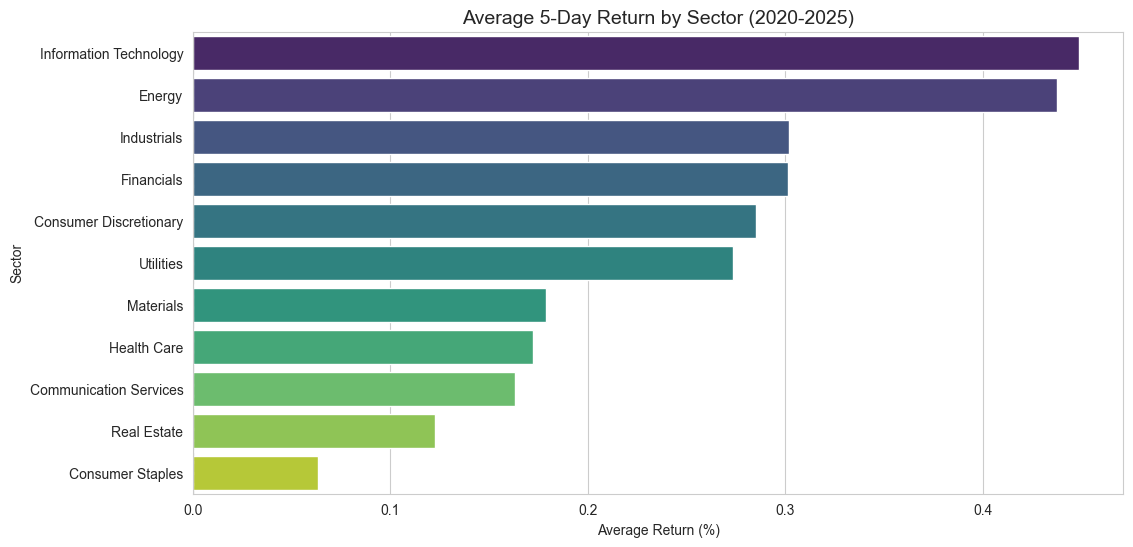

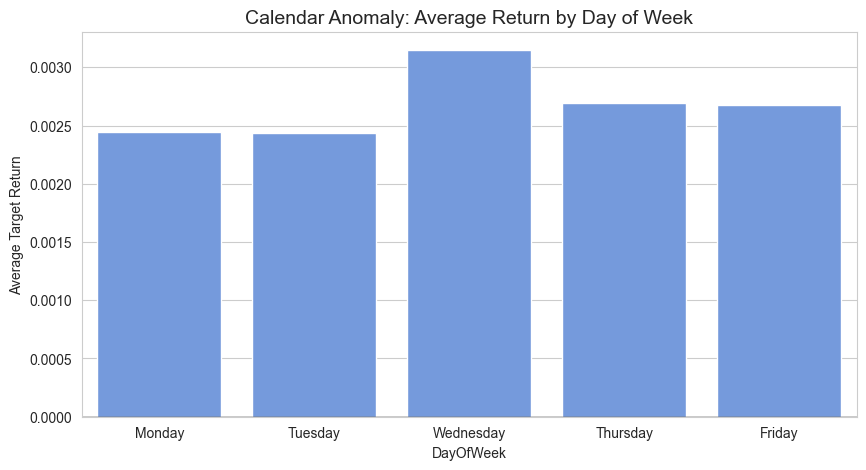


--- Step 2: Strict Split & Outlier Handling ---
Splitting data at 2025-01-01...
Train set: 2021-03-11 to 2024-12-31 (473587 rows)
Test set:  2025-01-02 to 2025-12-18 (120680 rows)
Calculating outlier bounds (1% - 99%) based on TRAIN set only...
Applying learned bounds to both Train and Test...
Data is clean and ready for modeling.
Starting Statistical EDA on TRAIN set...



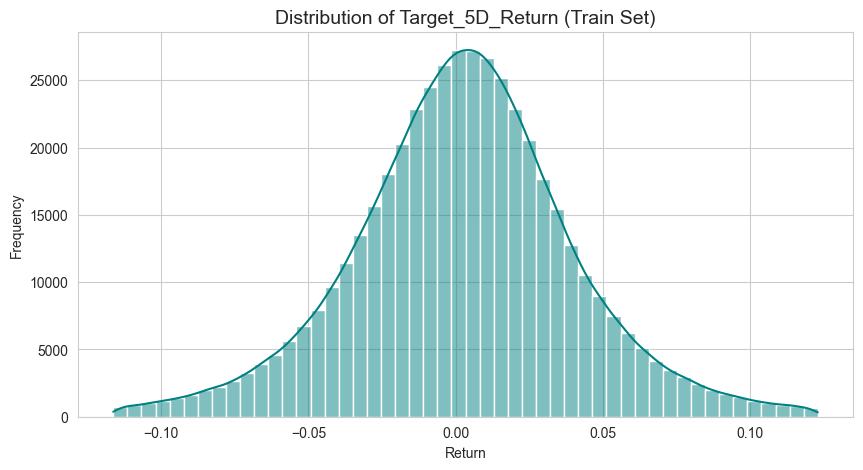

Target Skewness: 0.20
Target Kurtosis: 7.49
--------------------------------------------------


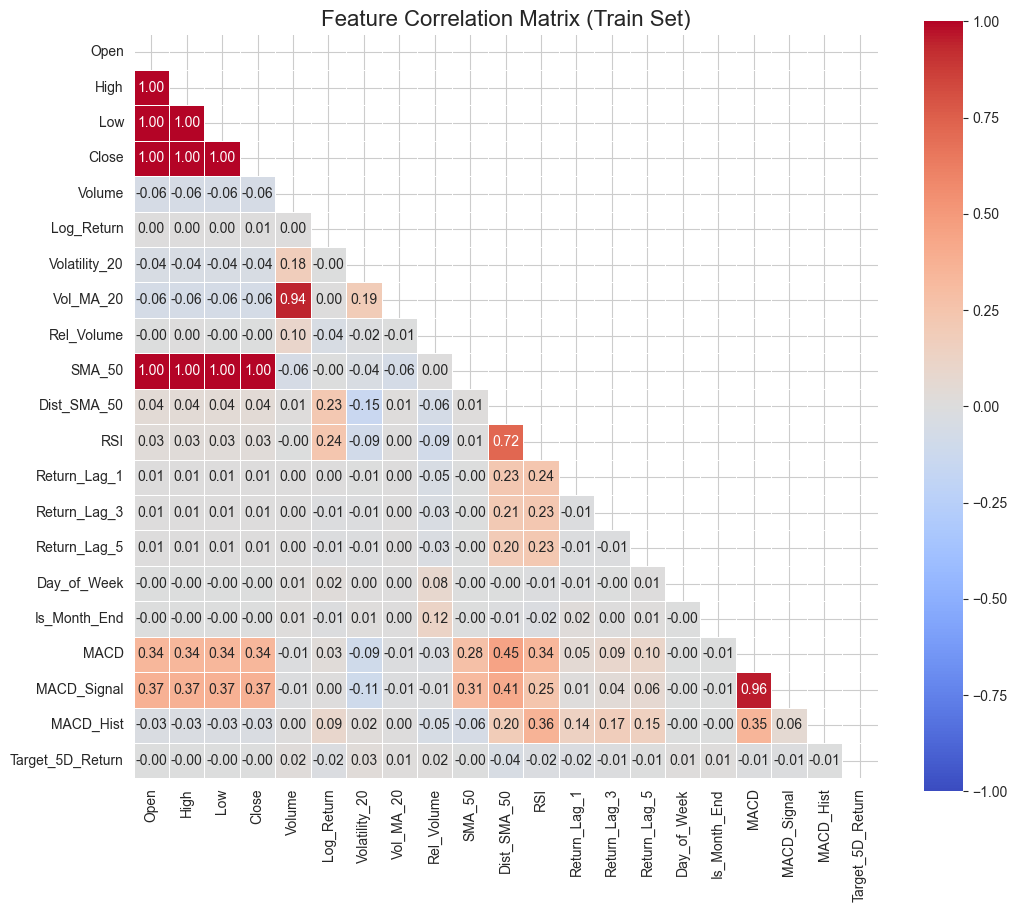

Top Correlations with Target_5D_Return:
Volatility_20    0.026926
Volume           0.016180
Rel_Volume       0.015269
Vol_MA_20        0.013587
Is_Month_End     0.013416
Day_of_Week      0.008331
SMA_50          -0.003504
Open            -0.004554
High            -0.004579
Low             -0.004656
Close           -0.004694
Return_Lag_5    -0.005454
MACD_Hist       -0.005625
Return_Lag_3    -0.012917
MACD_Signal     -0.013917
MACD            -0.014726
Log_Return      -0.016650
RSI             -0.018033
Return_Lag_1    -0.022986
Dist_SMA_50     -0.039645
Name: Target_5D_Return, dtype: float64
--------------------------------------------------


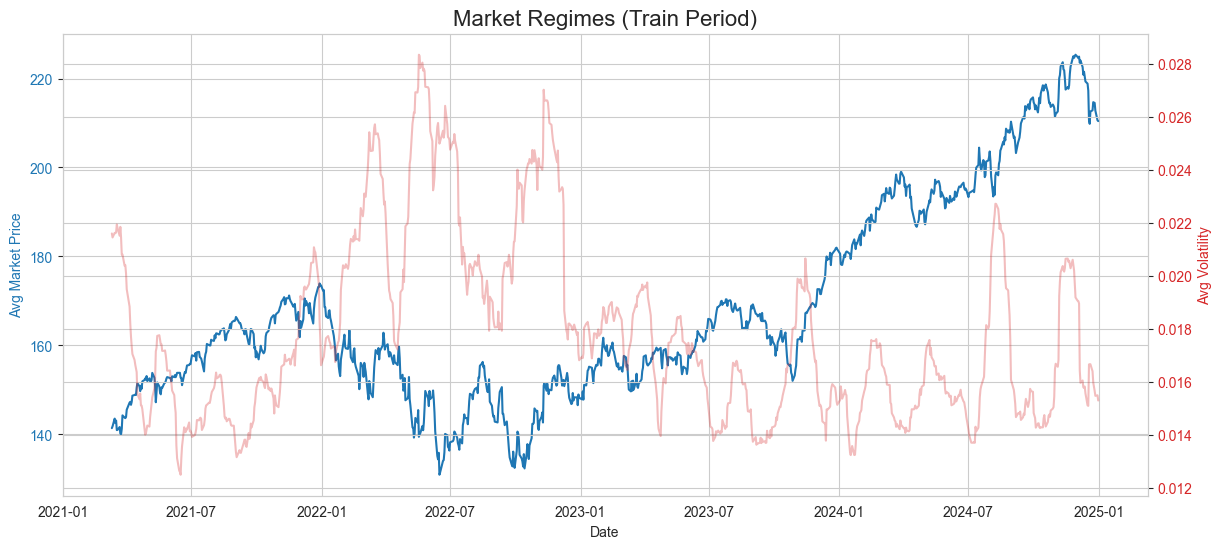

--------------------------------------------------

--- Time Series Properties for AAPL ---
ADF Statistic: -6.0368
p-value: 0.0000
Result: The target is STATIONARY (Good for modeling).


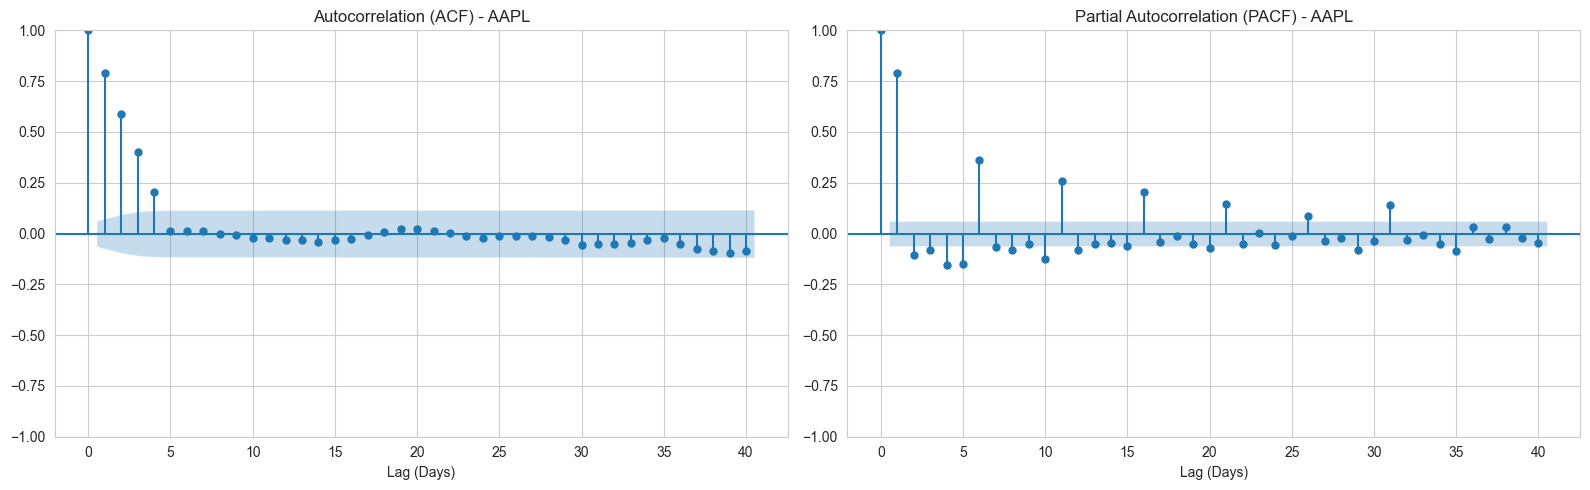

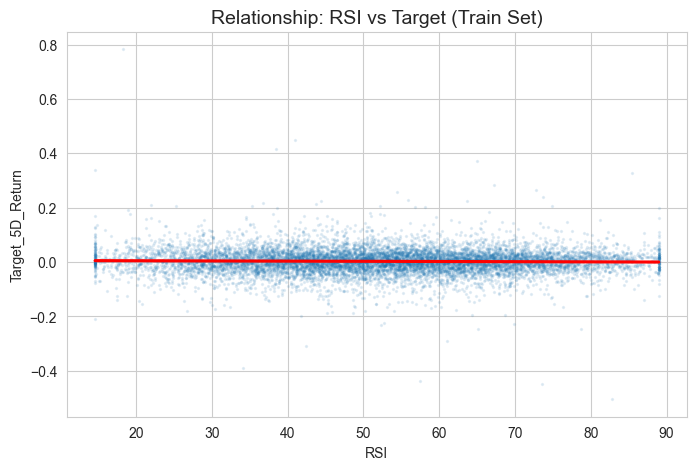

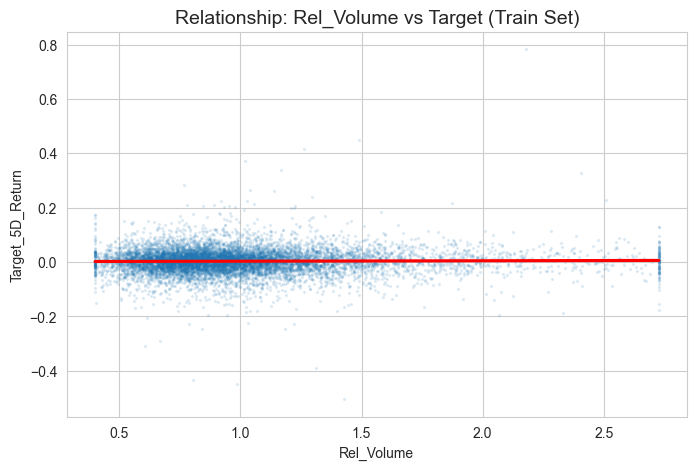

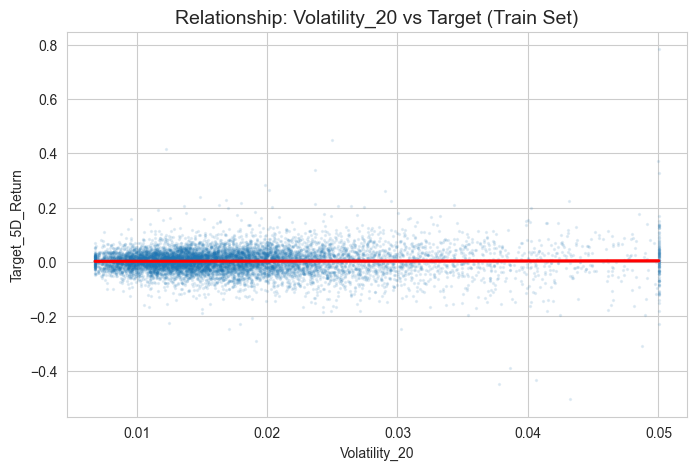

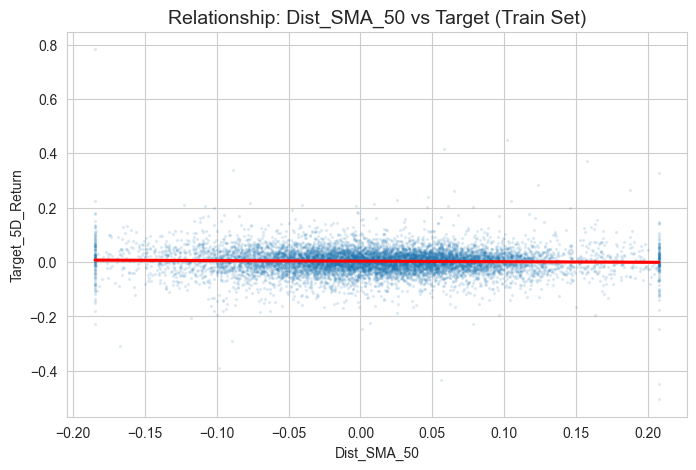

In [9]:

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


def check_time_series_properties(df, target_col='Target_5D_Return', ticker='AAPL'):

    """
    Performs Time Series Analysis (TSA) on a single asset to validate modeling assumptions.

    This function isolates a specific ticker to prevent statistical noise from cross-asset mixing
    and performs two critical checks:
    1. Stationarity Test (Augmented Dickey-Fuller): Determines if the statistical properties
       (mean, variance) remain constant over time, which is a prerequisite for most ML models.
    2. Memory Analysis (ACF/PACF): Visualizes serial correlation to identify how past returns
       influence future returns (identifying potential lag features).

    """
    if ticker not in df['Ticker'].values:
        ticker = df['Ticker'].iloc[0]

    print(f"\n--- Time Series Properties for {ticker} ---")

    series = df[df['Ticker'] == ticker][target_col].dropna()

    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")

    if result[1] < 0.05:
        print("Result: The target is STATIONARY (Good for modeling).")
    else:
        print("Result: The target is NON-STATIONARY (Needs differencing).")

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    plot_acf(series, lags=40, ax=axes[0], alpha=0.05, title=f'Autocorrelation (ACF) - {ticker}')
    axes[0].set_xlabel('Lag (Days)')

    plot_pacf(series, lags=40, ax=axes[1], alpha=0.05, title=f'Partial Autocorrelation (PACF) - {ticker}')
    axes[1].set_xlabel('Lag (Days)')

    plt.tight_layout()
    plt.show()

def plot_target_distribution(df, target_col='Target_5D_Return'):
    """
    Performs Univariate Analysis on the target variable.

    This function visualizes the distribution of returns to check for:
    1. Normality: Is the data bell-shaped?
    2. Skewness: Is the distribution leaning to the left (losses) or right (gains)?
    3. Kurtosis: Are there 'Fat Tails' (extreme events) compared to a normal distribution?

    Note: The plot clips the top/bottom 1% outliers to ensure the histogram is readable.
    """
    plt.figure(figsize=(10, 5))

    q_low = df[target_col].quantile(0.01)
    q_high = df[target_col].quantile(0.99)

    filtered_data = df[(df[target_col] > q_low) & (df[target_col] < q_high)]

    sns.histplot(filtered_data[target_col], bins=50, kde=True, color='teal')
    plt.title(f'Distribution of {target_col} (Train Set)', fontsize=14)
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.show()

    print(f"Target Skewness: {df[target_col].skew():.2f}")
    print(f"Target Kurtosis: {df[target_col].kurt():.2f}")
    print("-" * 50)

def plot_correlation_heatmap(df, target_col='Target_5D_Return'):

    numeric_df = df.select_dtypes(include=[np.number])

    corr_matrix = numeric_df.corr()

    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                mask=mask, vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

    plt.title('Feature Correlation Matrix (Train Set)', fontsize=16)
    plt.show()

    print(f"Top Correlations with {target_col}:")
    print(corr_matrix[target_col].drop(target_col).sort_values(ascending=False))
    print("-" * 50)

def plot_market_dynamics(df):

    """
    Temporal Analysis: Market Regimes & Volatility Analysis.

    This function visualizes the relationship between the general Market Trend (Mean Price)
    and Market Fear (Mean Volatility).

    Goal: To identify different 'Market Regimes' in the training data:
    - Bull Market: Typically characterized by rising prices and low volatility.
    - Bear Market / Crash: Characterized by sharp price drops and volatility spikes.
    """

    market_trend = df.groupby('Date')['Close'].mean()
    market_volatility = df.groupby('Date')['Volatility_20'].mean()

    fig, ax1 = plt.subplots(figsize=(14, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Avg Market Price', color=color)
    ax1.plot(market_trend.index, market_trend, color=color, label='Price')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Avg Volatility', color=color)
    ax2.plot(market_volatility.index, market_volatility, color=color, alpha=0.3, label='Volatility')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Market Regimes (Train Period)', fontsize=16)
    plt.show()
    print("-" * 50)

def plot_feature_vs_target(df, feature, target_col='Target_5D_Return'):

    """
    Bivariate Analysis: Assessing Linear Relationships.

    Visualizes the correlation between a selected feature and the target variable
    using a scatter plot overlaid with a linear regression line.

    Note: Uses random sampling (n=10,000) to prevent overplotting and ensure
    efficient rendering on large datasets.
    """

    if len(df) > 10000:
        sample_df = df.sample(n=10000, random_state=42)
    else:
        sample_df = df

    plt.figure(figsize=(8, 5))
    sns.regplot(x=feature, y=target_col, data=sample_df,
                scatter_kws={'alpha':0.1, 's': 2}, line_kws={'color':'red'})
    plt.title(f'Relationship: {feature} vs Target (Train Set)', fontsize=14)
    plt.show()

def run_statistical_eda(df):
    """
    Orchestrates the complete Exploratory Data Analysis (EDA) pipeline.

    This function executes a structured analysis flow:
    1. Univariate Analysis (Target Distribution).
    2. Bivariate Analysis (Correlations & Heatmaps).
    3. Market Dynamics (Regime Analysis).
    4. Time-Series Diagnostics (Stationarity & Memory).
    """
    print("Starting Statistical EDA on TRAIN set...\n")

    plot_target_distribution(df)
    plot_correlation_heatmap(df)
    plot_market_dynamics(df)

    # התוספת החדשה - מראה מקצועיות ב-Time Series!
    check_time_series_properties(df)

    features_to_check = ['RSI', 'Rel_Volume', 'Volatility_20', 'Dist_SMA_50']
    for feat in features_to_check:
        if feat in df.columns:
            plot_feature_vs_target(df, feat)


def split_and_clean_strictly(df, split_date='2025-01-01'):
    """
    Performs a strict time-series split and handles outliers without data leakage.

    Methodology:
    1. Splits data chronologically into Train and Test sets.
    2. Calculates outlier thresholds (1st and 99th percentiles) on the TRAIN set only.
    3. Applies these thresholds (Winsorization/Clipping) to both sets.
       This ensures the model is not exposed to future statistical distributions.
    """
    print(f"\n--- Step 2: Strict Split & Outlier Handling ---")
    print(f"Splitting data at {split_date}...")

    # Key numeric features to clean
    features = ['Log_Return', 'Volatility_20', 'Rel_Volume', 'Dist_SMA_50', 'RSI']

    # 1. Chronological Split (Time Series Split)
    train = df[df['Date'] < split_date].copy()
    test = df[df['Date'] >= split_date].copy()

    print(f"Train set: {train['Date'].min().date()} to {train['Date'].max().date()} ({len(train)} rows)")
    print(f"Test set:  {test['Date'].min().date()} to {test['Date'].max().date()} ({len(test)} rows)")

    # 2. Calculate Statistical Bounds (On TRAIN set only to prevent leakage)
    # We define "outliers" based strictly on historical data patterns.
    print("Calculating outlier bounds (1% - 99%) based on TRAIN set only...")
    lower_bounds = train[features].quantile(0.01)
    upper_bounds = train[features].quantile(0.99)

    # 3. Apply Clipping (Winsorization)
    # Future data (Test) is clipped using historical limits (Train bounds).
    print("Applying learned bounds to both Train and Test...")

    train[features] = train[features].clip(lower=lower_bounds, upper=upper_bounds, axis=1)
    test[features] = test[features].clip(lower=lower_bounds, upper=upper_bounds, axis=1)

    print("Data is clean and ready for modeling.")
    return train, test


if __name__ == "__main__":

    run_global_eda(full_dataset)

    train_clean, test_clean = split_and_clean_strictly(full_dataset)

    run_statistical_eda(train_clean) # Train only

In [10]:
full_dataset.head()

,Date,Ticker,Open,High,Low,Close,Volume,Log_Return,Volatility_20,Vol_MA_20,...,Return_Lag_3,Return_Lag_5,Day_of_Week,Is_Month_End,MACD,MACD_Signal,MACD_Hist,Target_5D_Return,Sector,DayOfWeek
23932,2021-03-11,A,117.556191,119.008459,117.052742,117.953148,1818700.0,0.015218,0.019390,1945940.0,...,-0.000517,-0.036796,3,0,-1.253625,-0.939150,-0.314474,0.006238,Health Care,Thursday
24421,2021-03-12,A,116.733267,118.146806,115.484316,117.575584,1368700.0,-0.003206,0.019011,1958265.0,...,0.031878,0.009951,4,0,-1.091598,-0.969640,-0.121958,0.010293,Health Care,Friday
24910,2021-03-15,A,117.072108,120.325188,116.510563,120.092827,1230000.0,0.021184,0.019603,1955865.0,...,0.001251,-0.000517,0,0,-0.751408,-0.925993,0.174586,-0.003467,Health Care,Monday
25399,2021-03-16,A,120.780250,121.322427,118.553436,119.085938,1345500.0,-0.008420,0.019660,1916515.0,...,0.015218,0.031878,1,0,-0.556636,-0.852122,0.295486,-0.008293,Health Care,Tuesday
25888,2021-03-17,A,118.446936,119.192437,117.633670,118.621208,1453000.0,-0.003910,0.019157,1778430.0,...,-0.003206,0.001251,2,0,-0.434766,-0.768651,0.333885,-0.013712,Health Care,Wednesday


# Train XGboost to predict 5 days return


--- Step 3: Modeling & Backtesting (With Learning Curve) ---
Training XGBoost Model...
[0]	validation_0-rmse:0.04430	validation_1-rmse:0.04752
[1]	validation_0-rmse:0.04429	validation_1-rmse:0.04751
[2]	validation_0-rmse:0.04428	validation_1-rmse:0.04751
[3]	validation_0-rmse:0.04428	validation_1-rmse:0.04751
[4]	validation_0-rmse:0.04427	validation_1-rmse:0.04750
[5]	validation_0-rmse:0.04426	validation_1-rmse:0.04749
[6]	validation_0-rmse:0.04425	validation_1-rmse:0.04749
[7]	validation_0-rmse:0.04425	validation_1-rmse:0.04749
[8]	validation_0-rmse:0.04424	validation_1-rmse:0.04749
[9]	validation_0-rmse:0.04424	validation_1-rmse:0.04748
[10]	validation_0-rmse:0.04423	validation_1-rmse:0.04748
[11]	validation_0-rmse:0.04422	validation_1-rmse:0.04748
[12]	validation_0-rmse:0.04422	validation_1-rmse:0.04748
[13]	validation_0-rmse:0.04421	validation_1-rmse:0.04748
[14]	validation_0-rmse:0.04421	validation_1-rmse:0.04748
[15]	validation_0-rmse:0.04420	validation_1-rmse:0.04748
[16]	valid

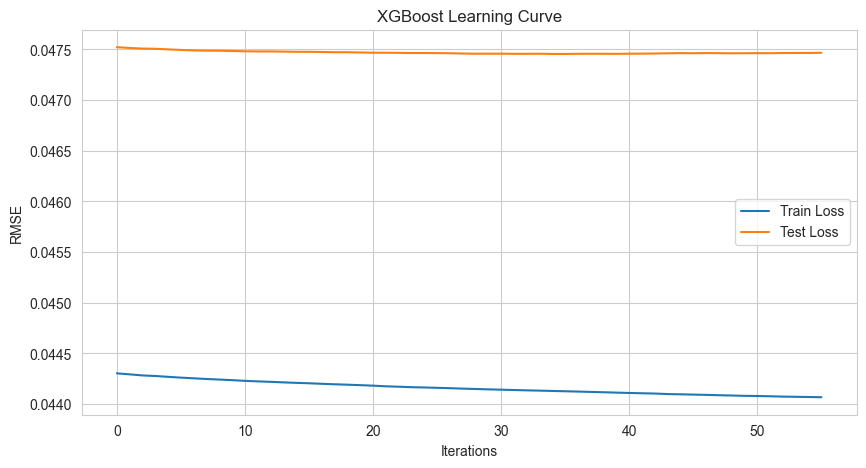

<Figure size 1000x500 with 0 Axes>

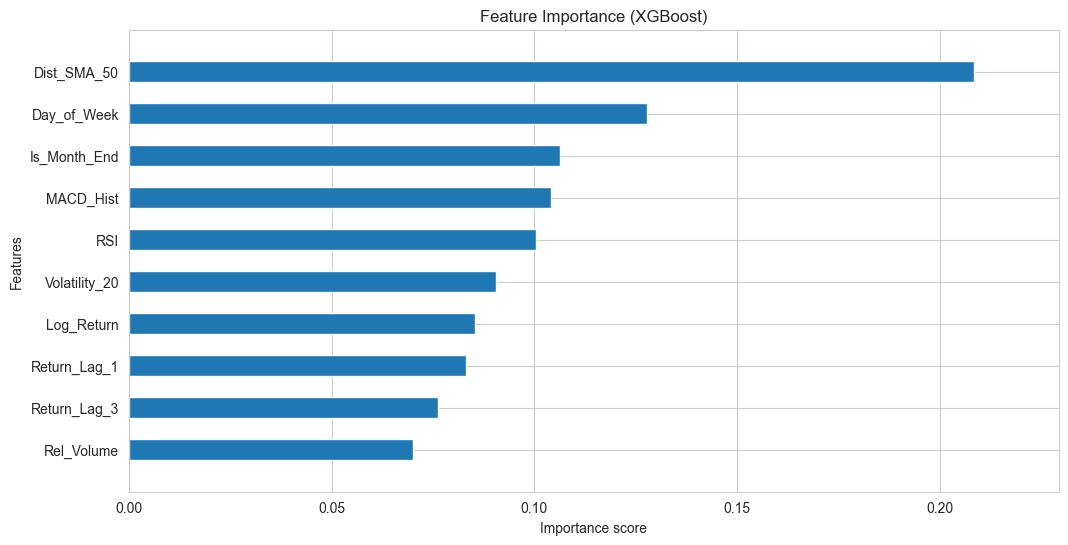

Running Backtest Strategy on Test Set...


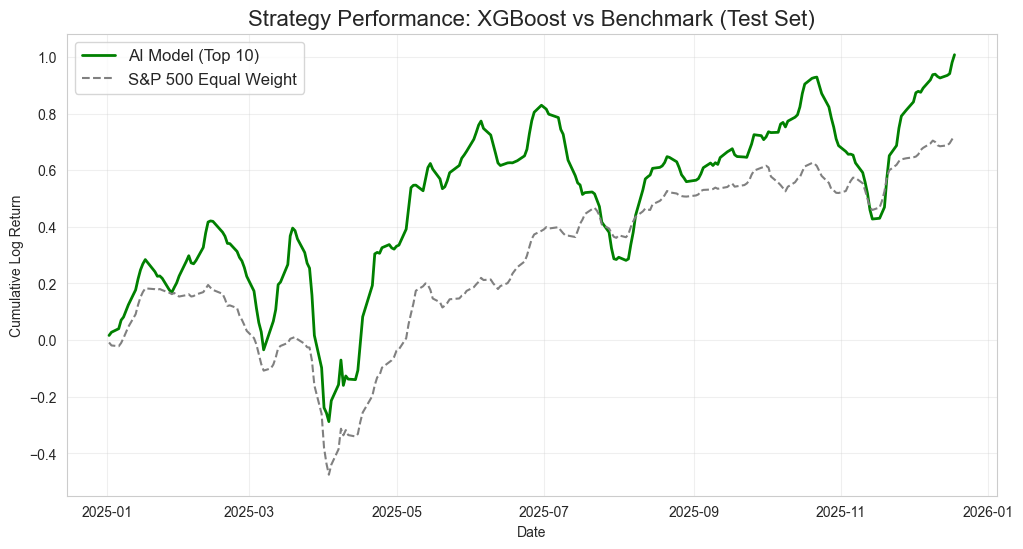

=== FINAL RESULTS (2024-2025) ===
Model Return:     100.81%
Benchmark Return: 72.16%
Alpha (Edge):     28.65%


In [23]:
features =[
        'Log_Return',
        'Volatility_20',
        'Rel_Volume',
        'Dist_SMA_50',
        'RSI',

        'Return_Lag_1',
        'Return_Lag_3',
        'MACD_Hist',
        'Is_Month_End',

        'Day_of_Week',
    ]

def train_predict_backtest(train_df, test_df):
    print("\n--- Step 3: Modeling & Backtesting (With Learning Curve) ---")

    train_clean['Sector_Id'] = train_clean['Sector'].astype('category').cat.codes
    test_clean['Sector_Id'] = test_clean['Sector'].astype('category').cat.codes


    target = 'Target_5D_Return'

    X_train = train_df[features]
    y_train = train_df[target]
    X_test = test_df[features]
    y_test = test_df[target]

    # --- XGBoost ---
    print("Training XGBoost Model...")

    model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=200,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,

            # ---  -Regularization ---
            reg_alpha=0.1,      # L1 Penalty
            reg_lambda=1.5,     # L2 Penalty

            random_state=42,
            n_jobs=-1,
            early_stopping_rounds=20,
        enable_categorical=True

        )

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True,
    )

    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, results['validation_0']['rmse'], label='Train Loss')
    plt.plot(x_axis, results['validation_1']['rmse'], label='Test Loss')
    plt.legend()
    plt.ylabel('RMSE')
    plt.xlabel('Iterations')
    plt.title('XGBoost Learning Curve')
    plt.show()

    # --- Feature Importance ---
    plt.figure(figsize=(10, 5))
    xgb.plot_importance(model, importance_type='gain', max_num_features=10, height=0.5, show_values=False)
    plt.title('Feature Importance (XGBoost)')
    plt.show()

    # --- (Backtest) ---
    print("Running Backtest Strategy on Test Set...")

    test_results = test_df.copy()
    test_results['Predicted_Return'] = model.predict(X_test)

    daily_returns = []
    benchmark_returns = []
    dates = []

    for date, group in test_results.groupby('Date'):
        if len(group) < 10: continue

        top_10_picks = group.nlargest(10, 'Predicted_Return')
        strategy_daily_return = top_10_picks['Target_5D_Return'].mean()
        market_daily_return = group['Target_5D_Return'].mean()

        daily_returns.append(strategy_daily_return)
        benchmark_returns.append(market_daily_return)
        dates.append(date)

    performance = pd.DataFrame({
        'Date': dates,
        'My_Strategy': daily_returns,
        'Benchmark': benchmark_returns
    }).set_index('Date')

    performance['My_Strategy_Cum'] = performance['My_Strategy'].cumsum()
    performance['Benchmark_Cum'] = performance['Benchmark'].cumsum()

    # --- Money Shot ---
    plt.figure(figsize=(12, 6))
    plt.plot(performance.index, performance['My_Strategy_Cum'], label='AI Model (Top 10)', color='green', linewidth=2)
    plt.plot(performance.index, performance['Benchmark_Cum'], label='S&P 500 Equal Weight', color='gray', linestyle='--')

    plt.title('Strategy Performance: XGBoost vs Benchmark (Test Set)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Log Return')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

    final_strat = performance['My_Strategy_Cum'].iloc[-1]
    final_bench = performance['Benchmark_Cum'].iloc[-1]

    print(f"=== FINAL RESULTS (2024-2025) ===")
    print(f"Model Return:     {final_strat:.2%}")
    print(f"Benchmark Return: {final_bench:.2%}")
    print(f"Alpha (Edge):     {final_strat - final_bench:.2%}")

    return model, performance

    return model, performance

if __name__ == "__main__":

    model, perf = train_predict_backtest(train_clean, test_clean)

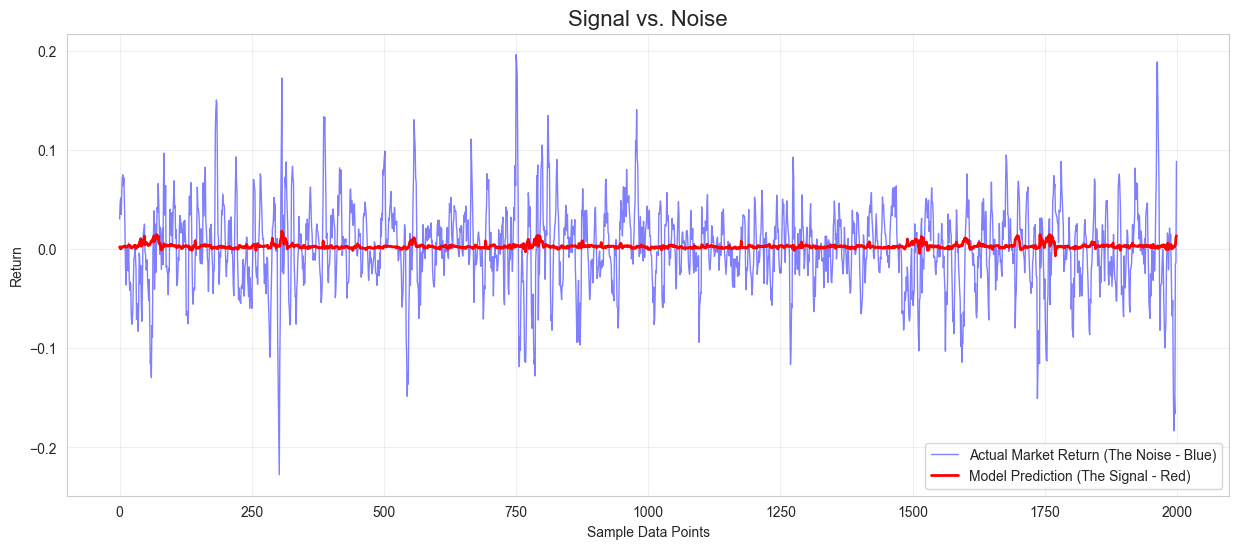

In [24]:

def plot_signal_vs_noise(model, df, features, n_points=2000):
    """
    Visualizes the contrast between the Model's Signal (Prediction) and Market Noise (Actual Returns).

    Purpose:
        To demonstrate the high Signal-to-Noise ratio characteristic of financial data.
        This plot visually explains the 'Irreducible Error' concept, showing that
        the RMSE stabilizes because the model tracks the underlying trend (Red)
        without overfitting to the random daily volatility (Blue).
    """
    # Select a continuous sample subset to prevent plot overcrowding
    sample = df.iloc[:n_points].copy()

    # Generate Model Predictions
    sample['Predicted'] = model.predict(sample[features])

    plt.figure(figsize=(15, 6))

    # Plot Actual Returns (Blue) - Represents Market "Noise" / Volatility
    plt.plot(range(n_points), sample['Target_5D_Return'],
             label='Actual Market Return (Noise)', color='blue', alpha=0.5, linewidth=1)

    # Plot Model Predictions (Red) - Represents the Detected "Signal" / Trend
    plt.plot(range(n_points), sample['Predicted'],
             label='Model Prediction (Signal)', color='red', linewidth=2)

    plt.title('Signal vs. Noise: Model Predictions vs. Actual Volatility', fontsize=16)
    plt.ylabel('Log Return')
    plt.xlabel('Sample Data Points (Time)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_signal_vs_noise(model, test_clean, features) # execute on testset

In [28]:

def evaluate_model_metrics(model, X_test, y_test):
    """
    Calculates key performance metrics for the financial regression model.

    Metrics:
    1. RMSE: Measures the magnitude of error (Precision).
    2. Information Coefficient (IC): Measures the ranking ability (Directional accuracy).
    """
    print("\n--- Statistical Evaluation ---")

    # Generate Predictions
    preds = model.predict(X_test)

    # 1. RMSE (Root Mean Squared Error)
    # Represents the standard deviation of prediction errors.
    # A lower RMSE indicates that predictions are closer to the actual values.
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"RMSE: {rmse:.4f} (Lower is better)")

    # 2. Information Coefficient (IC) - The "Gold Standard" in Quant Finance
    # Calculates the Spearman Rank Correlation between predictions and actual targets.
    # Goal: To verify if the model can correctly rank assets (e.g., Stock A will outperform Stock B),
    # regardless of the absolute error.
    # Benchmarks: IC > 0.05 is typically considered strong signal; IC > 0.1 is exceptional.
    ic, p_value = spearmanr(preds, y_test)
    print(f"Information Coefficient (IC): {ic:.4f} (Higher is better)")

    return rmse, ic


evaluate_model_metrics(model, test_clean[features], test_clean['Target_5D_Return'])


--- Statistical Evaluation ---
RMSE: 0.0475 (Lower is better)
Information Coefficient (IC): 0.0237 (Higher is better)


(np.float64(0.047454510260429766), np.float64(0.023713834339523853))

In [29]:
def get_todays_top_10(model, df, features):
    """
    Generates the final investment list based on the latest available data.

    This function isolates the most recent trading day, applies the trained model,
    and returns the top 10 ranked stocks sorted by their predicted future return.
    """
    print("\n--- Generating Top 10 Investment Recommendations ---")

    # 1. Identify the most recent trading date in the dataset
    latest_date = df['Date'].max()
    print(f"Date of recommendation: {latest_date.date()}")

    # 2. Filter data for the latest available date
    # We isolate the current market state to generate real-time rankings
    latest_data = df[df['Date'] == latest_date].copy()

    if latest_data.empty:
        print("Error: No data found for the latest date.")
        return None

    # 3. Generate Predictions (Ranking Scores)
    latest_data['Predicted_Score'] = model.predict(latest_data[features])

    # 4. Select the Top 10 stocks with the highest predicted returns
    top_10 = latest_data.nlargest(10, 'Predicted_Score')

    # 5. Format the output table for display
    # Selecting key metrics for the final report
    cols_to_show = ['Ticker', 'Sector', 'Close', 'Predicted_Score', 'RSI', 'Rel_Volume']

    # Ensure selected columns exist (handles cases where 'Sector' might be missing)
    cols_to_show = [c for c in cols_to_show if c in top_10.columns]

    final_table = top_10[cols_to_show].reset_index(drop=True)

    # Reset index to start from 1 (Rank 1-10) for better readability
    final_table.index = final_table.index + 1

    return final_table

top_10_stocks = get_todays_top_10(model, test_clean, features)

print("\nTop 10 Stocks to Buy Now (According to Model):")
display(top_10_stocks)


--- Generating Top 10 Investment Recommendations ---
Date of recommendation: 2025-12-18

Top 10 Stocks to Buy Now (According to Model):


,Ticker,Sector,Close,Predicted_Score,RSI,Rel_Volume
1,COIN,Financials,239.199997,0.017009,30.770984,1.021363
2,SMCI,Information Technology,29.370001,0.016150,27.510046,1.183351
3,NOW,Information Technology,153.380005,0.013206,38.296568,1.073306
4,ORCL,Information Technology,180.029999,0.012773,35.703098,1.064304
5,AVGO,Information Technology,329.250031,0.012411,25.393956,1.417634
6,LEN,Consumer Discretionary,108.330002,0.012195,18.628802,0.761780
7,GNRC,Industrials,136.990005,0.012188,38.035302,2.726241
8,HOOD,Financials,117.160004,0.012166,40.393419,0.855813
9,PSKY,Communication Services,13.010000,0.012130,27.843663,0.642309
10,UBER,Industrials,79.690002,0.011706,33.304981,0.822564


In [30]:
print("Environment versions:")
import sys
print(f"Python: {sys.version}")
import pandas as pd
print(f"Pandas: {pd.__version__}")
import xgboost
print(f"XGBoost: {xgboost.__version__}")

Environment versions:
Python: 3.13.1 (tags/v3.13.1:0671451, Dec  3 2024, 19:06:28) [MSC v.1942 64 bit (AMD64)]
Pandas: 2.3.3
XGBoost: 3.0.4
